    
# Comparative Analysis of Pneumonia Detection: Custom CNN vs. Transfer Learning Models

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Required Libraries

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from keras.applications import VGG16

### Set the random to specific number

In [3]:
# set random seed to 42 which is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)

### Creating a function for collecting metrices for this project

In [4]:
def store_results_to_dict(model, model_description):
    train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
    val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

    train_loss, train_acc = model.evaluate(train_generator, steps=train_steps_per_epoch)
    val_loss, val_acc = model.evaluate(val_generator, steps=val_steps_per_epoch)
    test_loss, test_acc = model.evaluate(test_generator, steps=test_steps_per_epoch)

    pred = model.predict(test_generator, steps=test_steps_per_epoch)
    pred_classes = np.round(pred)
    true_classes = test_generator.classes

    precision = precision_score(true_classes, pred_classes, average='binary')
    recall = recall_score(true_classes, pred_classes, average='binary')
    f1 = f1_score(true_classes, pred_classes, average='binary')

    curr_dict = {
        'Model': model_description,
        'Train Accuracy': round(train_acc, 4),
        'Train Loss': round(train_loss, 4),
        'Validation Accuracy': round(val_acc, 4),
        'Validation Loss': round(val_loss, 4),
        'Test Accuracy': round(test_acc, 4),
        'Test Loss': round(test_loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }
    return curr_dict


### Creating a function for plotting accuracy and loss of train and val dataset

In [5]:
def plot_acc_and_loss(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(12,5))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy',fontsize=20 )
  plt.legend()
  plt.figure(figsize=(12,5))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss', fontsize=20)
  plt.legend()
  plt.show()

### Obtaining data from the drive

In [6]:
# train, test and validation directories of x-ray dataset images
train_data_dir=('/content/drive/MyDrive/Pneumonia project/data/train')
val_data_dir=('/content/drive/MyDrive/Pneumonia project/data/val')
test_data_dir=('/content/drive/MyDrive/Pneumonia project/data/test')

### Count the number of normal and pneumonia images in each datasets

In [7]:
# counting number of normal images and pneumonia images in each dataset of training, testing and validation
path='/content/drive/MyDrive/Pneumonia project/data/'
# Numbers of pneumonia and normal images in each set
for folder in ['train', 'val', 'test']:
    count_normal = len(os.listdir(path + folder + '/NORMAL'))
    count_pneumonia = len(os.listdir(path + folder + '/PNEUMONIA'))
    print("There are {} normal images and {} pneumonia images in {} set. ".format(count_normal, count_pneumonia, folder))

There are 877 normal images and 1613 pneumonia images in train set. 
There are 321 normal images and 801 pneumonia images in val set. 
There are 327 normal images and 781 pneumonia images in test set. 


### For confirmation, Displaying an X-ray Image using OpenCV and Matplotlib

(1588, 1848, 3)


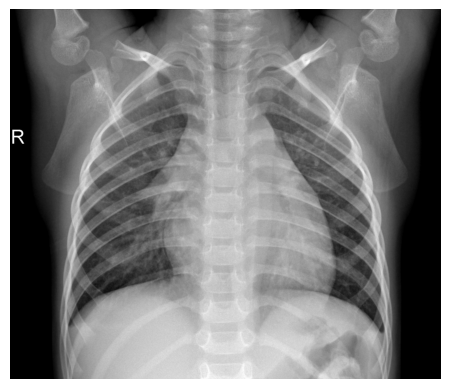

In [8]:
# Read the image
image = cv2.imread("/content/drive/MyDrive/Pneumonia project/data/train/NORMAL/IM-0452-0001.jpeg")
print(image.shape)
# OpenCV reads images in BGR format, let's convert it to RGB for Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

### Loading X-ray Images for Classification

In [9]:
# Defining the categories of images and the desired size for resizing
image_categories = ['PNEUMONIA', 'NORMAL']
image_size = 150

# Defining a function to load images from a folder
def load_images_from_folder(all_images_folder_path):

  # Initializing lists to store images and their labels
  all_images = []
  all_labels = []

  # Here we are iterating through each category ('PNEUMONIA', 'NORMAL')
  for cat in tqdm(image_categories):
    cat_path = os.path.join(all_images_folder_path, cat)
    for image in os.listdir(cat_path):
      try:
        image = cv2.imread(os.path.join(cat_path, image), cv2.IMREAD_GRAYSCALE)
        image_resized = cv2.resize(image, (image_size, image_size))
        all_images.append(image_resized)
        all_labels.append(cat)
      except Exception as e:
        print("the error while loading image is", e)
  return all_images,all_labels

### Loading X-ray Images into Training, Validation, and Testing Sets

In [10]:
images_train, labels_train = load_images_from_folder(train_data_dir)

100%|██████████| 2/2 [01:15<00:00, 37.53s/it]


In [11]:
images_val, labels_val = load_images_from_folder(val_data_dir)

100%|██████████| 2/2 [00:30<00:00, 15.07s/it]


In [12]:
images_test, labels_test = load_images_from_folder(test_data_dir)

100%|██████████| 2/2 [00:27<00:00, 13.58s/it]


### Visualizing Initial and Final X-ray Images with Labels in Training Dataset

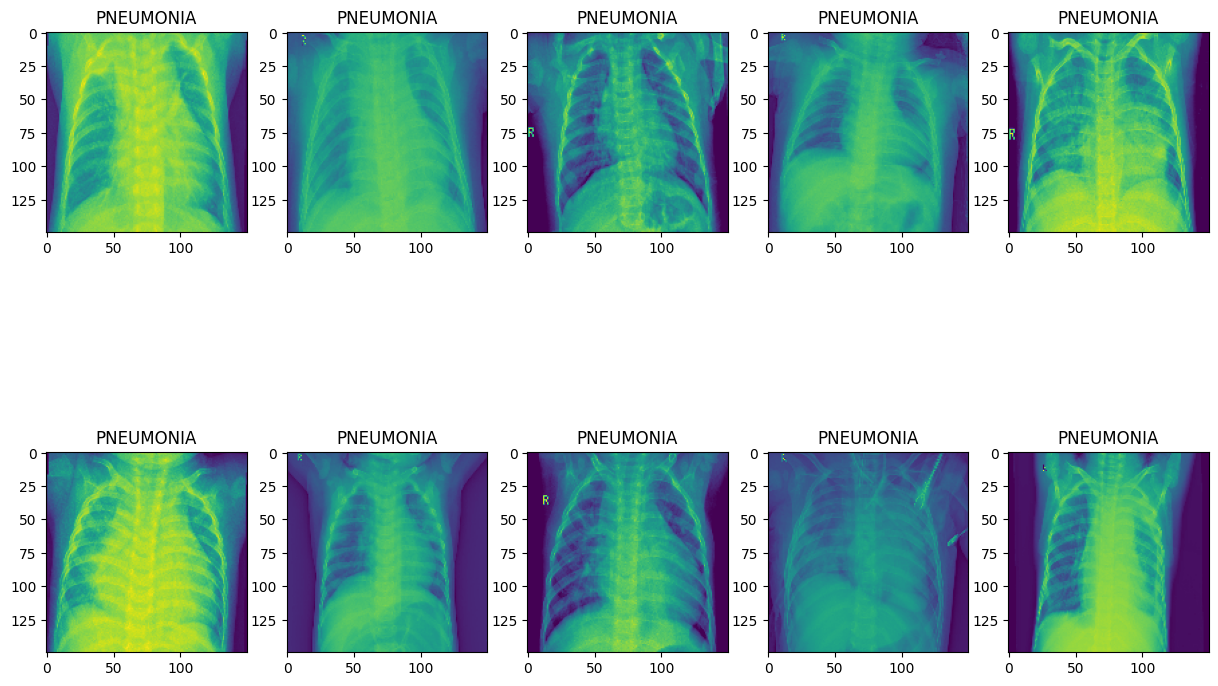

In [13]:
# Here we create a 2x5 grid to display the first 10 images and their labels
plt.figure(figsize=(15,10))  # Creating a figure with a size of 15x10 inches

for i in range(10):  # Iterating through the first 10 images
    plt.subplot(2,5,i+1)  # Dividing the figure into a 2x5 grid and select the i+1th subplot
    plt.imshow(images_train[i])
    plt.title(labels_train[i])

plt.show()

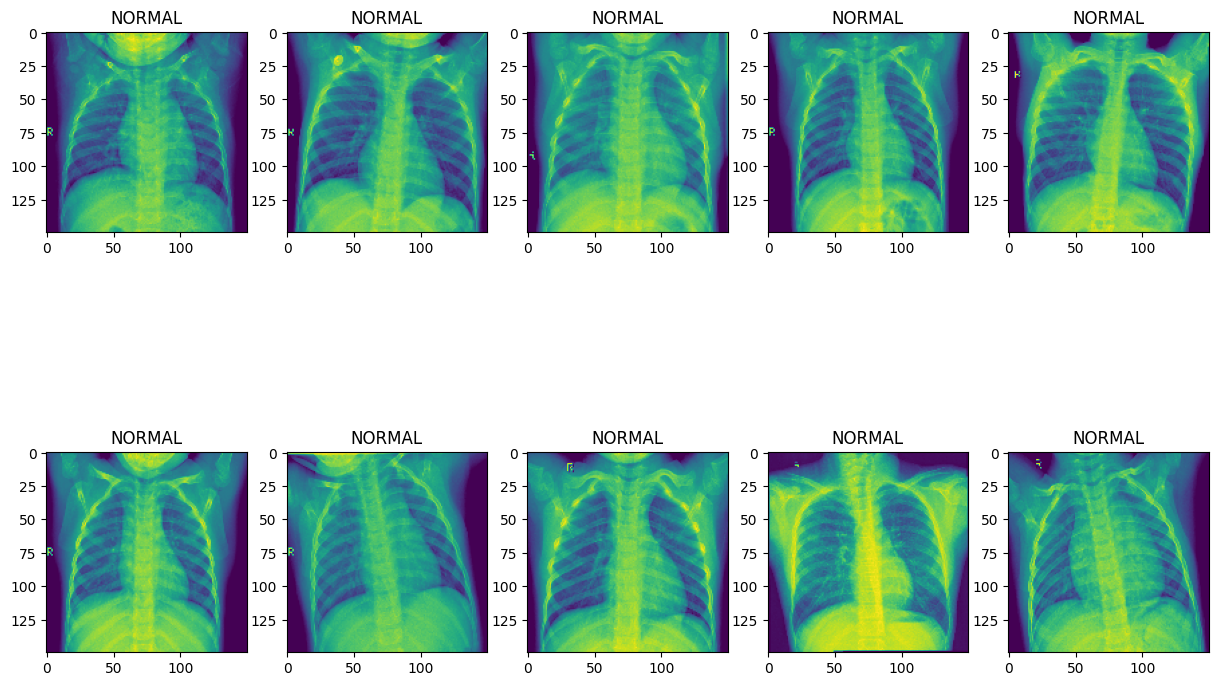

In [14]:
plt.figure(figsize=(15,10))  # Creating a figure with a size of 15x10 inches
count = 0

# Here we create a 2x5 grid to display the last 10 images and their labels
for i in range(len(images_train)-10, len(images_train)):
    count += 1
    plt.subplot(2,5,count)  # Creating subplots in a 2x5 grid
    plt.imshow(images_train[i])
    plt.title(labels_train[i])

plt.show()

### Visualizing the Distibution of Normal Images and Pneumonia Images in each dataset

In [15]:
total_images_train_normal = os.listdir(path + 'train/NORMAL')
total_images_train_pneumonia = os.listdir(path + 'train/PNEUMONIA')

total_images_test_normal = os.listdir(path + 'test/NORMAL')
total_images_test_pneumonia = os.listdir(path + 'test/PNEUMONIA')

total_images_val_normal = os.listdir(path + 'val/NORMAL')
total_images_val_pneumonia = os.listdir(path + 'val/PNEUMONIA')

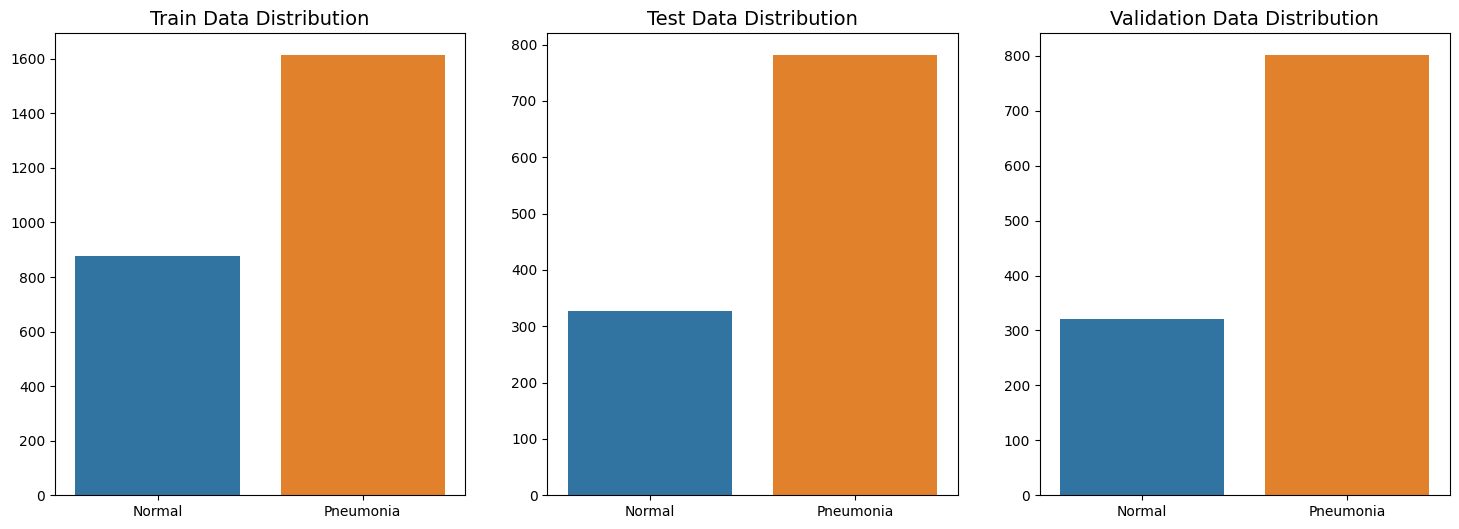

In [16]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title('Train Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
plt.subplot(132)
plt.title('Test Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_test_normal),len(total_images_test_pneumonia)])
plt.subplot(133)
plt.title('Validation Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_val_normal),len(total_images_val_pneumonia)])
plt.show()

### Preprocessing Images Data

In [17]:
# Get all the data in the directory DATA/TRAIN, and reshape them
print("Train dataset:")
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_data_dir,
                                                                         target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/TEST , and reshape them
print("Test dataset:")
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

# Get all the data in the directory DATA/VAL, and reshape them
print("Validation dataset:")
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                       target_size=(150, 150), batch_size=32, class_mode='binary')

Train dataset:
Found 2490 images belonging to 2 classes.
Test dataset:
Found 1108 images belonging to 2 classes.
Validation dataset:
Found 1122 images belonging to 2 classes.


In [18]:
# Counting the stepsize per epoch
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)

### Image Augmentation Initialization

In [19]:
train_datagen = ImageDataGenerator(rotation_range=40,
                               	width_shift_range=0.2,
                               	height_shift_range=0.2,
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

### Building Convolutional Neural Network (CNN) Architecture

In [20]:
model = Sequential()

# Creating custom layers
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### Compiling the model

In [21]:
# defining call back
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 50, 50, 64)        0         
                                                        

### Training the model

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

# Fit the model with training data, using data augmentation and early stopping
history = model.fit(
                   train_generator,
                   steps_per_epoch = train_steps_per_epoch,
                   callbacks = [early_stop],
                   epochs = 25,
                   validation_data = val_generator,
                   validation_steps = val_steps_per_epoch
)

Epoch 1/25
78/78 [==============================] - 65s 666ms/step - loss: 0.4384 - acc: 0.8068 - val_loss: 0.2889 - val_acc: 0.8824
Epoch 2/25
78/78 [==============================] - 45s 577ms/step - loss: 0.2105 - acc: 0.9229 - val_loss: 0.1753 - val_acc: 0.9358
Epoch 3/25
78/78 [==============================] - 42s 543ms/step - loss: 0.1827 - acc: 0.9293 - val_loss: 0.1610 - val_acc: 0.9394
Epoch 4/25
78/78 [==============================] - 43s 557ms/step - loss: 0.1300 - acc: 0.9506 - val_loss: 0.1163 - val_acc: 0.9581
Epoch 5/25
78/78 [==============================] - 51s 662ms/step - loss: 0.1313 - acc: 0.9498 - val_loss: 0.1162 - val_acc: 0.9590
Epoch 6/25
78/78 [==============================] - 43s 554ms/step - loss: 0.1019 - acc: 0.9606 - val_loss: 0.1098 - val_acc: 0.9635
Epoch 7/25
78/78 [==============================] - 51s 659ms/step - loss: 0.1038 - acc: 0.9590 - val_loss: 0.0911 - val_acc: 0.9679
Epoch 9/25
78/78 [==============================] - 42s 541ms/step - 

### Results

In [24]:
results = store_results_to_dict(model, 'Custom CNN model')
# Appending the results of the new model
results_final = []
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

35/35 [==============================] - 10s 261ms/step


,Model,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss,Precision,Recall,F1 Score
0,Custom CNN model,0.9811,0.0497,0.9724,0.0834,0.9016,0.3554,0.888,0.9846,0.9338


### Plotting Training and Validation Accuracy & Loss across Epochs

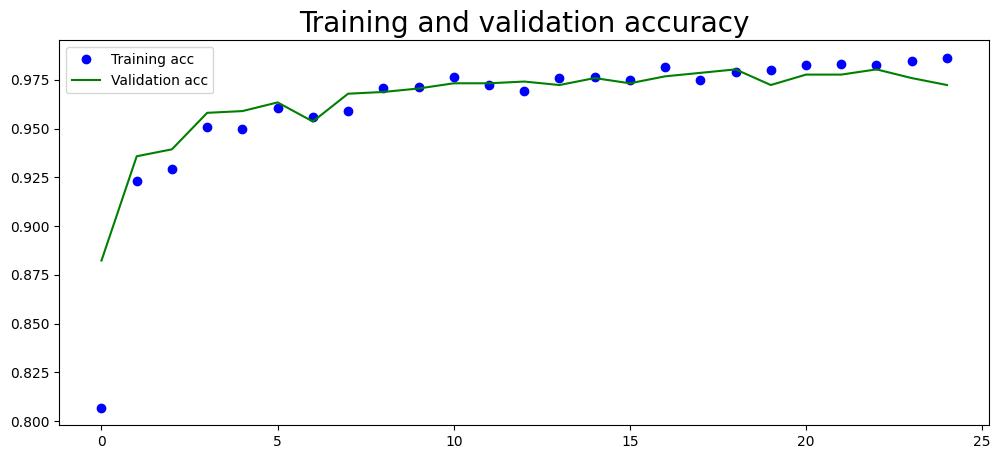

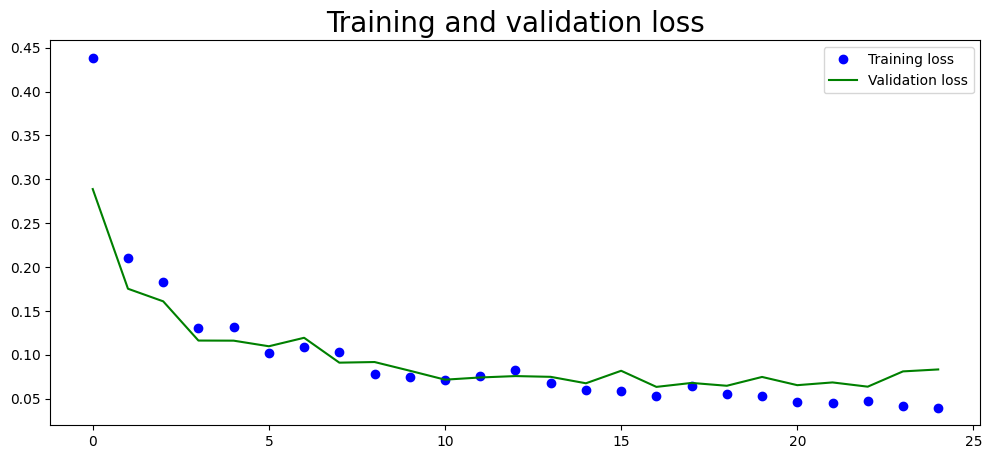

In [25]:
plot_acc_and_loss(history)

### Saving the best model

In [26]:
model.save("Best_model_Custom_CNN.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Visualizing Confusion Matrix and Classification report which shows precision, recall and f1-score

35/35 [==============================] - 14s 382ms/step
Custom CNN:

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.95      0.70      0.81       327
   PNEUMONIA       0.89      0.98      0.93       781

    accuracy                           0.90      1108
   macro avg       0.92      0.84      0.87      1108
weighted avg       0.91      0.90      0.90      1108

----------------------------------------------------
Confusion Matrix of Custom CNN:



Text(0.5, 1.0, 'Confusion Matrix')

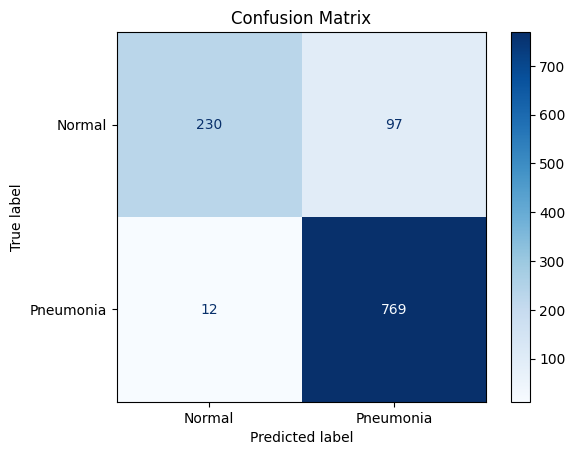

In [27]:
pred = model.predict(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print("Custom CNN:\n")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

print("----------------------------------------------------")
cm = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix of Custom CNN:\n")
cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

## Transfer learning VGG16 model
### Initializing VGG16 Model with Transfer Learning

#### Data Augmentation

In [28]:
# ImageDataGenerator for data augmentation and loading images
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,
                               	width_shift_range=0.2,
                               	height_shift_range=0.2,
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


In [29]:
train_generator = train_datagen.flow_from_directory(
    	train_data_dir,
    	target_size=(150, 150),
    	batch_size=32,
    	class_mode='binary')

val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

Found 2490 images belonging to 2 classes.
Found 1122 images belonging to 2 classes.


### we use the weight of pretrained model "imagenet"

In [30]:
vgg_model_base = VGG16(weights='imagenet',
                  include_top=False, # we only import conv base layers
                  input_shape=(150,150,3))

58889256/58889256 [==============================] - 2s 0us/step


### Freezing the layers

In [31]:
for layer in vgg_model_base.layers:
  layer.trainable = False

In [32]:
vgg_model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Creating a Transfer Learning Model atop VGG16

#### This process leverages the pre-trained convolutional base of VGG16 for feature extraction and adds custom fully connected layers for fine-tuning the model to perform a specific classification task.

In [33]:
transfer_model_vgg=Sequential()
transfer_model_vgg.add(vgg_model_base)
transfer_model_vgg.add(Flatten())
transfer_model_vgg.add(Dense(256,activation='relu'))
transfer_model_vgg.add(Dense(1,activation='sigmoid'))

In [34]:
transfer_model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Configuring Early Stopping and Compiling Transfer Learning Model

In [35]:
adam = Adam(learning_rate=2e-5)
transfer_model_vgg.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
early_stop = EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True)

### ImageDataGenerator for data augmentation

In [36]:
# Training the transfer learning model
np.random.seed(42)
tf.random.set_seed(42)

history = transfer_model_vgg.fit( train_generator,
                          	     steps_per_epoch=train_steps_per_epoch,
                          	     epochs=25,
                                 callbacks = [early_stop],
                          	     validation_data=val_generator,
                          	     validation_steps=val_steps_per_epoch
)

Epoch 1/25
78/78 [==============================] - 67s 807ms/step - loss: 0.4541 - acc: 0.8004 - val_loss: 0.3112 - val_acc: 0.9100
Epoch 2/25
78/78 [==============================] - 63s 805ms/step - loss: 0.3141 - acc: 0.8932 - val_loss: 0.2666 - val_acc: 0.8975
Epoch 3/25
78/78 [==============================] - 60s 777ms/step - loss: 0.2666 - acc: 0.9076 - val_loss: 0.2625 - val_acc: 0.8948
Epoch 4/25
78/78 [==============================] - 59s 754ms/step - loss: 0.2598 - acc: 0.9060 - val_loss: 0.2096 - val_acc: 0.9171
Epoch 5/25
78/78 [==============================] - 59s 755ms/step - loss: 0.2416 - acc: 0.9064 - val_loss: 0.2311 - val_acc: 0.9055
Epoch 6/25
78/78 [==============================] - 58s 743ms/step - loss: 0.2274 - acc: 0.9149 - val_loss: 0.2044 - val_acc: 0.9153
Epoch 7/25
78/78 [==============================] - 60s 771ms/step - loss: 0.2205 - acc: 0.9185 - val_loss: 0.2330 - val_acc: 0.9118
Epoch 8/25
78/78 [==============================] - 57s 739ms/step - 

### Results

In [37]:
results = store_results_to_dict(transfer_model_vgg, 'Transfer learning model-VGG16')
# Appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

35/35 [==============================] - 15s 420ms/step


,Model,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss,Precision,Recall,F1 Score
0,Custom CNN model,0.9811,0.0497,0.9724,0.0834,0.9016,0.3554,0.8880,0.9846,0.9338
1,Transfer learning model-VGG16,0.9434,0.1677,0.9439,0.1478,0.9251,0.2167,0.9418,0.9526,0.9472


### Plotting Training and Validation Accuracy & Loss across Epochs

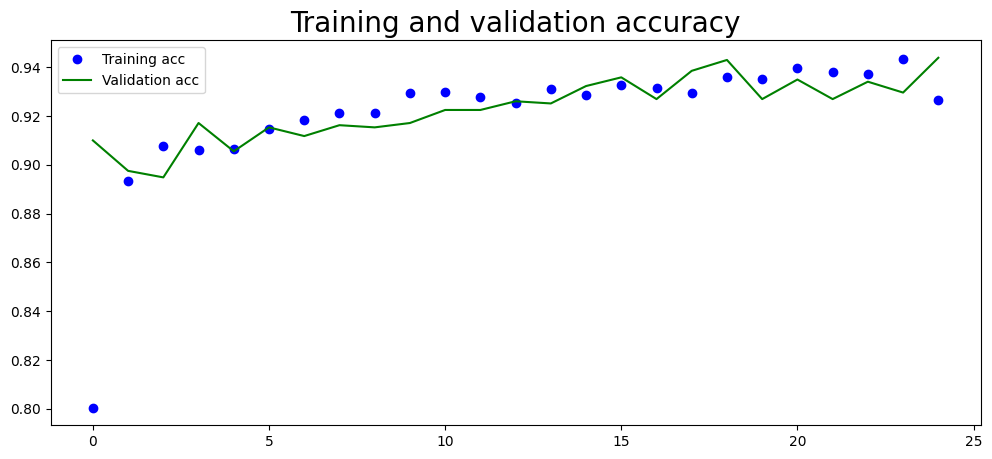

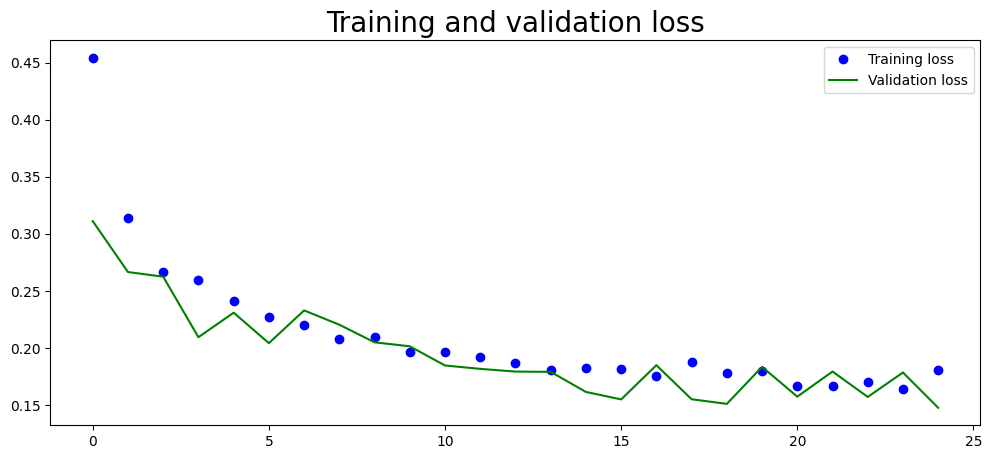

In [38]:
plot_acc_and_loss(history)

### Saving the best model VGG16

In [39]:
model.save("Best_model_VGG16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Visualizing Confusion Matrix and Classification report which shows precision, recall and f1-score

35/35 [==============================] - 12s 341ms/step
Transfer learning model-VGG16:

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.88      0.86      0.87       327
   PNEUMONIA       0.94      0.95      0.95       781

    accuracy                           0.93      1108
   macro avg       0.91      0.91      0.91      1108
weighted avg       0.92      0.93      0.92      1108

----------------------------------------------------
Confusion Matrix of Transfer learning model-VGG16:



Text(0.5, 1.0, 'Confusion Matrix')

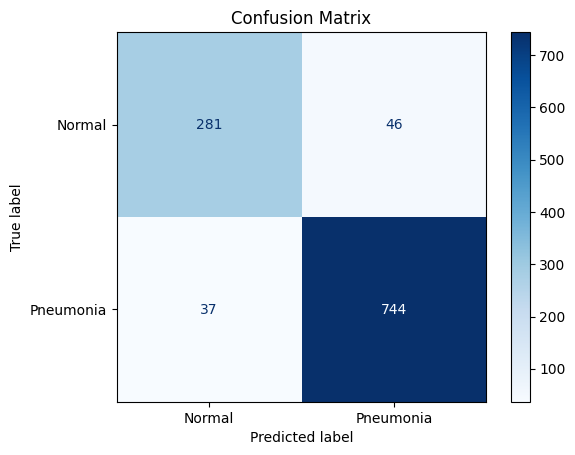

In [40]:
pred = transfer_model_vgg.predict(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Transfer learning model-VGG16:\n")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

print("----------------------------------------------------")
cm = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix of Transfer learning model-VGG16:\n")
cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')